# Graph Coloring Problem With Different Optimization Algorithms

#### Import Section

In [1]:
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from random import choice
import numpy as np
from numpy.random import choice
import sys
from collections import defaultdict
from collections	import defaultdict, deque
from copy 			import deepcopy
from os				import system
from random         import randrange
import random
import os
import tqdm
import pandas as pd
import math
from itertools import chain
import operator

#### Global Variables

In [301]:
# Generation random.seed for every algorithm.
seed = 1773

# Generation max iteration for every algorithm
max_iterations = 10000

#### Reading data files

In [3]:
# Reading file_names for every algorithm.
fileNames = []
for root, dirs, files in os.walk("./data/", topdown=False):
    for name in files:
        if name.startswith('gc_'):
            fileNames.append(name)
#print(*fileNames, sep='\n' )

#### Global methods

In [4]:
# Generating matrix from given file
def generateMatrixFromFile (file_name):
    """
    Read the graph from the input file and create the adjacency matrix
    """
    global numNodes
    global numEdges
    lines = open('data/' + file_name).readlines()

    # get the number of nodes and total links
    tokens = lines[0].split()
    numNodes = int(tokens[0])
    numEdges = int(tokens[1])

    # create matrix for connections in graph
    matrix = np.zeros((numNodes, numNodes))
    for line in lines[1 : numEdges+1]:
        tokens = line.split()
        node = int(tokens[0])
        link_to_node = int(tokens[1])
        
        # Replaces '0' with '1' wherever there is an edge
        matrix[node][link_to_node] = 1
        matrix[link_to_node][node] = 1

    return matrix

<i>Difference between adjacency list and adjacency matrix: https://www.geeksforgeeks.org/comparison-between-adjacency-list-and-adjacency-matrix-representation-of-graph/</i>

In [5]:
#Generate adjacency list from adjacency matrix 
def adjacenecy_matrix_to_adjacency_list(matrix):
	adjacency_list = defaultdict(list)
	for row in range(0, len(matrix)):
		for element in range(0, len(matrix[row])):
			if matrix[row][element] == 1:
				adjacency_list[row].append(element)
	return dict(adjacency_list)

In [6]:
def plot_colored_graph(coloring,total_color,adjacency_list, accuracy):
    G = nx.Graph()
    for node, edges in adjacency_list.items():
        G.add_node(node)
        for edge in edges:
            G.add_edge(node, edge)

    colors = [coloring[node] for node in G.nodes()]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=colors)
    plt.title('The total color number used in this graph: ' + str(total_color) + " with accuracy: %" + str(round(accuracy, 2)))
    # Show the graph
    plt.show()

In [7]:
#Checks accuracy of a given colored graph and its adjacency list.
def check_accuracy(coloring, graph):
    accuracy = 0
    for node, color in coloring.items():
        for neighbor in graph[node]:
            if coloring[neighbor] == color:
                accuracy += 1
    total_edges = sum([len(graph[node]) for node in graph])
    return (total_edges - accuracy) / total_edges * 100


In [8]:
def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

In [9]:
def plot_difference(df):
    # Group the dataframe by fileName and algorithm
    grouped = df.groupby(['fileName','algorithm'])['minimumColor'].min()
    # Plot the grouped dataframe
    grouped.unstack().plot(kind='bar', stacked=False)
    # Show the plot
    plt.show()

In [299]:
def plot_results():
    results = pd.DataFrame(columns=['fileName','algorithm','minimumColor'])
    
    for fileName in fileNames:
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'Greedy', 'minimumColor': greedy_results[fileName][1]})
        results = append_row(results, new_row)
    
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'TabuSearch', 'minimumColor': tabu_results[fileName][1]})
        results = append_row(results, new_row)
        
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'SimulatedAnnealing', 'minimumColor': sa_results[fileName][1]})
        results = append_row(results, new_row)
        
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'OptimizedSimulatedAnnealing', 'minimumColor': optimized_sa_results[fileName][1]})
        results = append_row(results, new_row)
        
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'GeneticAlgorithm', 'minimumColor': ga_results[fileName][1]})
        results = append_row(results, new_row)
        
        
    plot_difference(results)

In [11]:
#Plots first solution for every file.
def plot_graphs(dict_algoritm_result):
    for fileName in greedy_results:
        accuracy = check_accuracy(dict_algoritm_result[fileName][0],fileName_adj_list[fileName])
        plot_colored_graph(dict_algoritm_result[fileName][0],dict_algoritm_result[fileName][1],fileName_adj_list[fileName],accuracy)

### 🏁  Starting Point

In [12]:
#Generate Matrix from every file
fileName_adj_matrix = {}

#Generate Adjacency List from every Matrix
fileName_adj_list = {}

for fileName in fileNames:
    fileName_adj_matrix[fileName] = generateMatrixFromFile(fileName)
    fileName_adj_list[fileName] = adjacenecy_matrix_to_adjacency_list(fileName_adj_matrix[fileName])
    
#print(fileName_adj_matrix)
#print(fileName_adj_list.keys())

### 🔴 1- TABU SEARCH

<i> Tabu search algorithm is a metaheuristic optimization algorithm that combines the benefits of both local search and random search. The tabu list helps to avoid getting stuck in local optima and the predefined moves or operators help to explore the search space more efficiently. </i>

#### Step 1 
<br>
<li> Initialize the current solution, best solution, and tabu list. The current solution is the starting point for the search and the best solution is the best solution found so far. The tabu list is used to keep track of previously visited solutions, so that they are not revisited in the near future. Here, as a first solution, we will assign a color to each node with using the greedy approach. </li>

In [13]:
def greedy_coloring(adj_matrix):
    # Get the number of nodes in the graph
    n = len(adj_matrix)
    # Initialize a list to store the colors of each node
    colors = [0] * n
    # Assign the first color to the first node
    colors[0] = 1
    # Iterate over the remaining nodes
    for i in range(1, n):
        # Create a set to store the available colors
        available_colors = set(range(1, n+1))
        # Iterate over the neighboring nodes
        for j in range(n):
            # Check if the current node is connected to the neighboring node
            if adj_matrix[i][j] == 1:
                # Remove the color of the neighboring node from the available colors set
                if colors[j] in available_colors:
                    available_colors.remove(colors[j])
        # Assign the first available color to the current node
        colors[i] = min(available_colors)
        color_dict = {i: colors[i] for i in range(n)}
    return color_dict, len(set(color_dict.values()))

In [14]:
greedy_results={}
for fileName in fileNames:
    greedy_results[fileName] = greedy_coloring(fileName_adj_matrix[fileName])

#Print the last file
#print(greedy_results[fileName])


#### Step 2
<br>
<li> Lets plot the greedy result: </li>

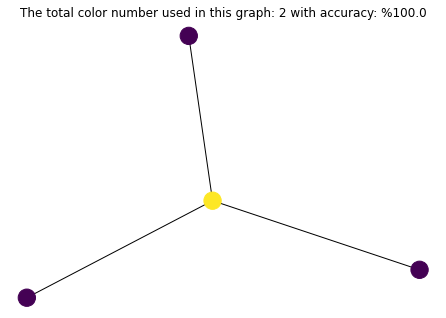

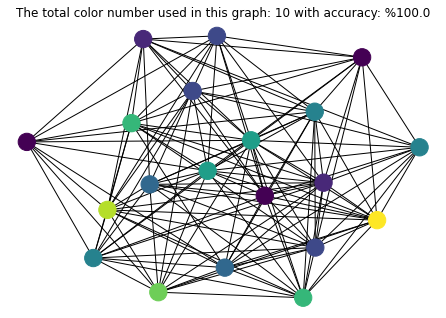

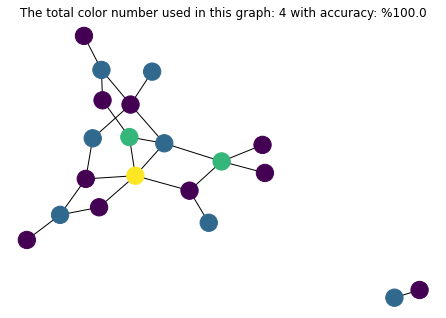

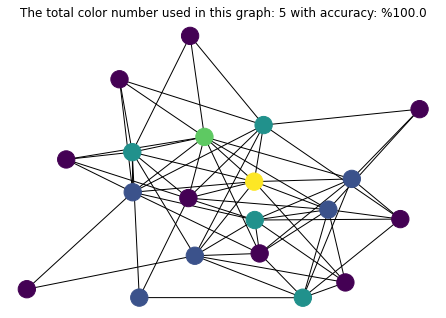

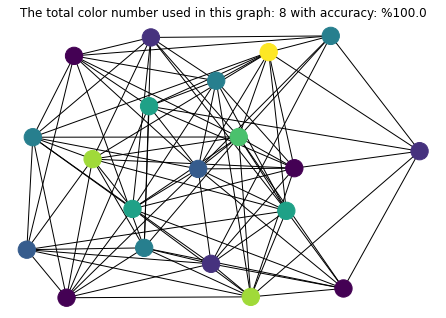

In [15]:
plot_graphs(greedy_results)

#### Step 3
<br>
<li> The Tabu Search Algorithm </li>

In [16]:
tabu_size = 7
tabu_reps = 40

In [17]:
def tabu_search(adjacency_list, greedy_result_dict, greedy_result_number):
	first_coloring = True
	result = greedy_result_dict
	for v in range(greedy_result_number, 1, -1):
		status, result = tabu_coloring(adjacency_list, v, result, first_coloring)
		if not status:
			break
		first_coloring = False
	
	return result, len(set(result.values()))

In [18]:
def tabu_coloring(adjacency_list, number_of_colors, previous_solution, is_first_solution):
	"""
    A function to solve the graph coloring problem using tabu search
    """
    # create a list of available colors
	colors = list(range(number_of_colors))
	iterations = 0
    
    # create a tabu list and an aspiration dictionary
	tabu_list = deque()
	aspiration_dict = {}
    # create a copy of the previous solution
	solution = deepcopy(previous_solution)
    
    # if it's not the first solution, assign a random color to all vertices with color greater than the number of colors
	if not is_first_solution:
		for i in range(len(adjacency_list)):
			if solution[i] >= number_of_colors:
				solution[i] = colors[random.randrange(0, len(colors))]

	while iterations < max_iterations:
		candidates = set()
		conflict_count = 0
        
        # check for conflicting edges and add the vertices to the candidates set
		for vertice, edges in adjacency_list.items():
			for edge in edges:
				if solution[vertice] == solution[edge]:
					candidates.add(vertice)
					candidates.add(edge)
					conflict_count += 1

		candidates = list(candidates)
    
        # if no conflicts are found, the solution is valid
		if conflict_count == 0:
			break

		new_solution = None
		for _ in range(tabu_reps):
            # choose a random vertex from the candidates
			vertice = candidates[random.randrange(0, len(candidates))]
			new_color = colors[random.randrange(0, len(colors))]
            
            # if the new color is the same as the current color, choose the last color in the list
			if solution[vertice] == new_color:
				new_color = colors[-1]

			new_solution = deepcopy(solution)
			new_solution[vertice] = new_color
			new_conflicts = 0
        
            # check for conflicts in the new solution
			for vertice, edges in adjacency_list.items():
				for edge in edges:
					if vertice is not None and edge is not None and new_solution[vertice] == new_solution[edge]:
						new_conflicts += 1
                        
			# if the new solution has less conflicts than the current solution, or the vertex-color combination is in the aspiration dictionary
			if new_conflicts < conflict_count:
				if new_conflicts <= aspiration_dict.setdefault(conflict_count, conflict_count - 1):
					aspiration_dict[conflict_count] = new_conflicts - 1
					if (vertice, new_color) in tabu_list:
						tabu_list.remove((vertice, new_color))
						break
				else:
					if (vertice, new_color) in tabu_list:
						continue
				break

		tabu_list.append((vertice, solution[vertice]))
		if len(tabu_list) > tabu_size:
			tabu_list.popleft()

		solution = deepcopy(new_solution)
		iterations += 1

	if conflict_count != 0:
		return False, previous_solution
	else:
		return True, solution


#### Step 4
<br>
<li> Run Tabu Search Algorithm with different tabu search algorithm parameters </li>

In [19]:
tabu_results = {}
for fileName in tqdm.tqdm(fileNames):
    tabu_results[fileName] = tabu_search(fileName_adj_list[fileName], greedy_results[fileName][0], greedy_results[fileName][1])

100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


#### Step 5
<br>
<li> Print Tabu Search Results </li>

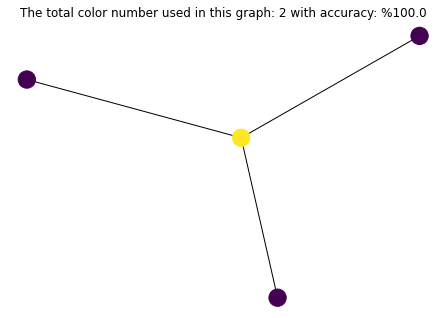

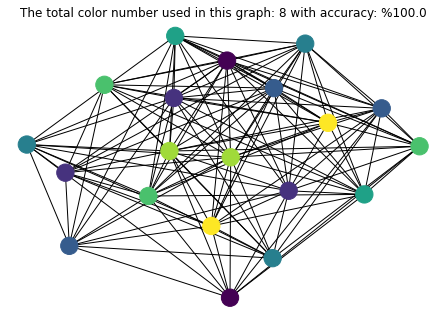

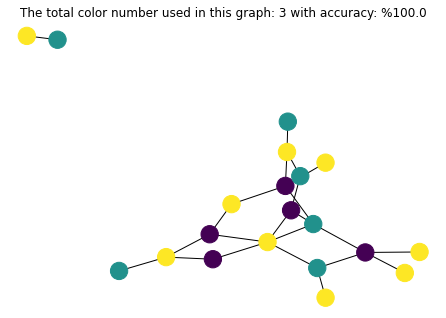

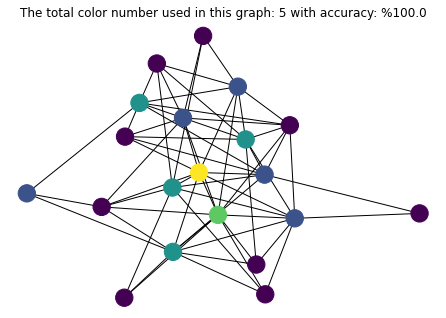

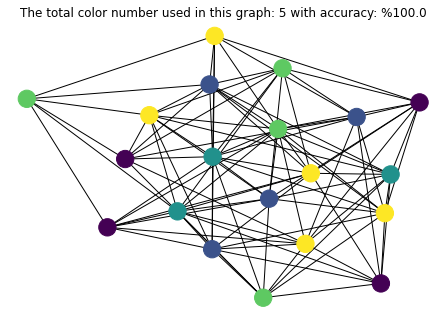

In [20]:
plot_graphs(tabu_results)

### 🔴 2- SIMULATED ANNEALING

Simulated Annealing (SA) is a probabilistic optimization technique that is often used to find approximate solutions to difficult or complex optimization problems. The basic idea behind SA is to start with a random solution, and then repeatedly make small changes (called moves) to the solution, accepting or rejecting each change based on a probability function. The probability function is defined by a temperature parameter that starts high and gradually decreases over time. At high temperatures, the algorithm is more likely to accept worse solutions, allowing it to explore the search space more thoroughly. As the temperature decreases, the algorithm becomes more selective and the solutions become closer to the optimal solution.


#### Step 1 
<br>
<li> Initialization. </li>

In [21]:
T_start = 100
T_end = 1
alpha = 0.99

#second part
tabu_list_size = 20

#### Step 2 
<br>
<li> The Simulated Annealing Algorithm </li>

In [22]:
def simulated_annealing(adj_matrix, adj_list, T_start, T_end, alpha):
    random.seed(seed)
    # Get the number of nodes in the graph
    n = len(adj_matrix)
    # Initialize a list to store the colors of each node
    colors = [0] * n
    # Assign a random color to each node
    for i in range(n):
        colors[i] = random.randint(1, n)
    # Set the initial temperature
    T = T_start
    # Initialize the best solution
    best_colors = colors.copy()
    for iteration in range(max_iterations):
        # Select a random node
        i = random.randint(0, n-1)
        # Generate a candidate solution by changing the color of the selected node
        candidate_colors = colors.copy()
        candidate_colors[i] = random.randint(1, n)
        # Calculate the difference in quality between the candidate solution and the current solution
        delta_E = 0
        for neighbor in adj_list[i]:
            if candidate_colors[i] == candidate_colors[neighbor]:
                delta_E += 1
        # Accept the candidate solution with a probability that depends on the difference in quality and the current temperature
        if delta_E <= 0 or random.random() < math.exp(-delta_E/T):
            colors = candidate_colors
        # Update the best solution
        if delta_E < 0:
            best_colors = candidate_colors.copy()
        # Update the temperature
        T = T*alpha
        # Check if the temperature has reached the end temperature
        if T < T_end:
            break
    color_dict = {i: best_colors[i] for i in range(n)}
    return color_dict,len(set(color_dict.values()))


#### Step 3
<br>
<li> The Results of Simulated Annealing Algorithm </li>

In [23]:
sa_results = {}
for fileName in tqdm.tqdm(fileNames):
    sa_results[fileName] = simulated_annealing(fileName_adj_matrix[fileName],fileName_adj_list[fileName],T_start,T_end,alpha)

100%|██████████| 5/5 [00:00<00:00, 646.81it/s]


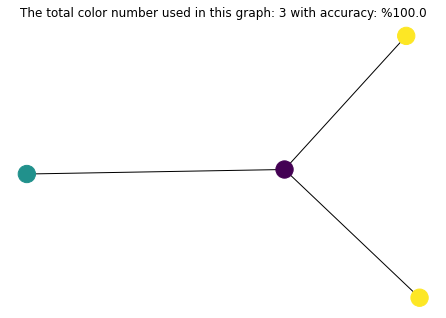

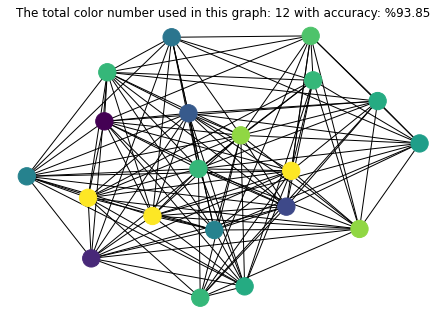

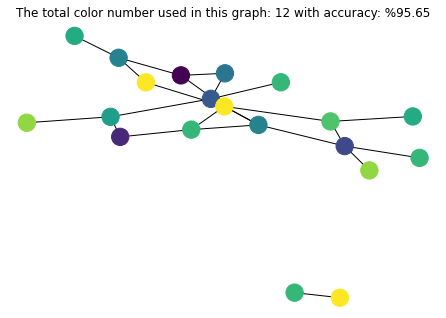

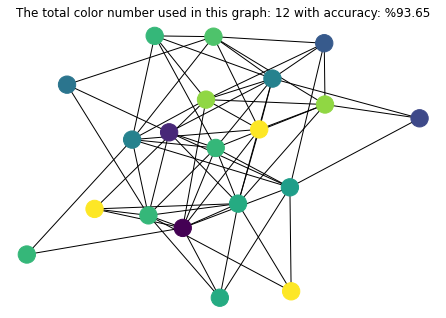

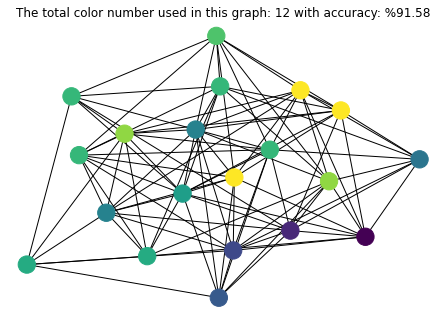

In [24]:
plot_graphs(sa_results)

#### Step 4
<br>
<li> Accuracy was low. Therefore, the new application of the Simulated Annealing Algorithm is made with the following differences. </li>

The solution provided by the simulated annealing algorithm is an approximate solution, it may not always produce the optimal solution. However, there are ways to make it more accurate for graph coloring problem:

<ol>
<li>Use a better move function: The move function used in the current code assigns a random color to the selected node. You can use a more sophisticated move function that considers the colors of the neighboring nodes, such as a move function that selects the least used color among the neighboring nodes.</li>

<li>Use a better cooling schedule: The cooling schedule used in the current code is a geometric cooling schedule with alpha as a constant. You can use a more sophisticated cooling schedule that adapts the temperature based on the search progress, such as a fast annealing schedule or a simulated tempering schedule.</li>

<li>Use Tabu list: The tabu list is a data structure that keeps track of the recently visited solutions, it helps to avoid cycling.</li>

<li>Use a better acceptance criterion: The acceptance criterion used in the current code is based on the Metropolis criterion, which only considers the difference in energy between the current solution and the candidate solution. You can use a more sophisticated acceptance criterion that takes into account the current temperature, such as the boltzmann acceptance criterion or the saphira acceptance criterion.</li>

<li>Use a hybrid approach: You can combine simulated annealing with other optimization algorithms such as genetic algorithm or particle swarm optimization to improve the performance and accuracy of the solution</li>

<li>Use a better initialization: The current code uses a random initialization for the coloring, you can use different initialization methods such as Welsh Powell, Largest first, Matula etc.</li>
</ol>

By applying these changes to the algorithm, it will be more accurate in solving the graph coloring problem, but it's important to note that it still doesn't guarantee to give an optimal solution.

In [25]:
def simulated_annealing_with_optimal_changes(adj_matrix, adj_list, T_start, T_end, alpha):
    n = len(adj_matrix)
    # Initialize a list to store the colors of each node
    colors = [0] * n
    # Assign the initial color to each node
    for i in range(n):
        colors[i] = i+1
    # Set the initial temperature
    T = T_start
    # Initialize the best solution
    best_colors = colors.copy()
    previous_best_colors = colors.copy()
    # Create a tabu list data structure to keep track of the recently visited solutions
    tabu_list = defaultdict(int)
    for iteration in range(max_iterations):
        # Select a random node
        i = random.randint(0, n-1)
        # Generate a candidate solution by changing the color of the selected node using 
        # a move function that selects the least used color among the neighboring nodes
        candidate_colors = colors.copy()
        used_colors = [colors[j] for j in adj_list[i] if colors[j]!=0]
        available_colors = list(set(range(1, n+1)) - set(used_colors))
        candidate_colors[i] = min(available_colors, key=lambda x: tabu_list[x])
        # Calculate the difference in quality between the candidate solution and the current solution
        delta_E = 0
        for neighbor in adj_list[i]:
            if candidate_colors[i] == candidate_colors[neighbor]:
                delta_E += 1
        # Accept the candidate solution using boltzmann acceptance criterion
        prob = min(1, math.exp(-delta_E/T))
        if random.random() < prob:
            colors = candidate_colors
            tabu_list[colors[i]] += 1
            if len(tabu_list) > tabu_list_size:
                tabu_list.pop(min(tabu_list, key=tabu_list.get))
        # Update the best solution
        if delta_E < 0:
            best_colors = candidate_colors.copy()
            previous_best_colors= best_colors.copy()
        # check if there are neighboring nodes with the same color
        for j in range(n):
            if adj_matrix[i][j]==1 and colors[i]==colors[j]:
                colors= previous_best_colors.copy()
                break
        # Update the temperature using simulated tempering schedule
        T = T*alpha
        # Check if the temperature has reached the end temperature
        if T < T_end:
            break
    color_dict = {i: best_colors[i] for i in range(n)}
    return color_dict,len(set(color_dict.values()))

#### Step 5
<br>
<li> Print Optimized Simulated Annealing Results </li>

In [26]:
optimized_sa_results = {}
for fileName in tqdm.tqdm(fileNames):
    optimized_sa_results[fileName] = simulated_annealing_with_optimal_changes(fileName_adj_matrix[fileName],fileName_adj_list[fileName],T_start,T_end,alpha)

100%|██████████| 5/5 [00:00<00:00, 125.46it/s]


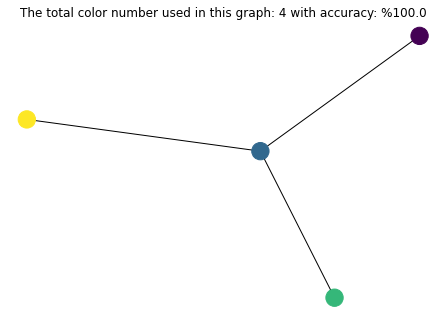

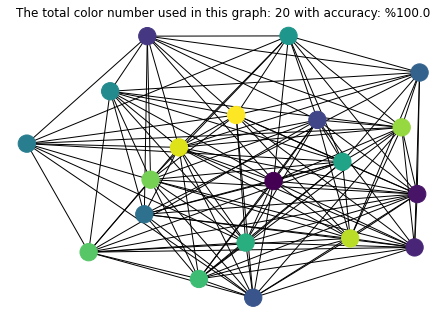

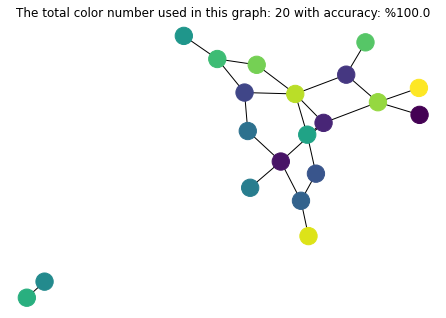

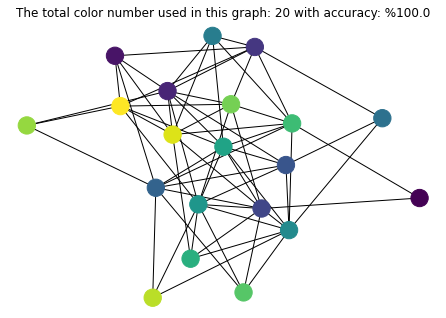

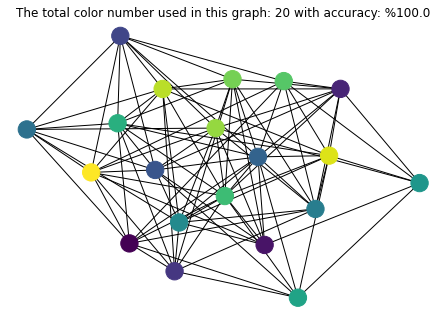

In [27]:
plot_graphs(optimized_sa_results)

### 3- GENETIC ALGORITHM

In [295]:
mutation_prob = 0.01
import random

In [310]:
################### make random adjacency matrix for problem ###################
def graph_generator (node):
    adj_graph=[]
    n=len(node)
    for i in range(0,n):
        adj_graph.append([0])
        for j in range(i+1,n):
            adj_graph[i].append(int(node[i][j]))
            
    return(adj_graph)

# initialize population (population size =100 and chromosome_size = node_number)#
def initialisation(chromosome,color): 
    pop= dict()
    n=chromosome
    m=color
    for i in range (1,101):
        l=list()
        for j in range(0,n):
            l.append(random.randint(1,m))
        pop[i]=l
        l=[]
    #for obj in list(pop.keys()): #for test initialisation result
     #   print( obj ,pop[obj])
    return(pop)
################### compute fitness for each choromosome ###################
def fittnes_func(graph,node, arr): 
    n=node
    chorom_Arr = arr
    rank=0
    ii = 0
    while ii < n:
        count = ii
        color = chorom_Arr[ii]
        l=ii
        for j in graph[l]:
            if j == 1 and color != chorom_Arr[count]:
                rank +=1000
            elif j == 0:
                rank = rank+10
            count +=1
        ii += 1
    return(rank)

################### selection_roulette wheel  ###################
def selection(fitness): 
    pr=random.uniform(0,0.98)
    select=0
    count = 0
    while select < pr :
        count +=1
        select += fitness[count]
    if count == 100:
        return(count-1)
    else:
        return(count)

################### one point cross over ###################
def crossover_func(l1,l2,len_,graph,clr): 
    n=len_
    point=random.randint(0,n)
    l1[point: ] , l2[point: ] = l2[point: ] , l1[point: ]
    #print(l1,l2) #test new chromosome

    #Mutation
    mutation(l1,n,graph,clr)
    mutation(l2,n,graph,clr)

    return(l1,l2)

################### mutation ###################
def mutation(l1,len__ , graph,clr_): 
    p=random.uniform(0,0.99)
    n=len__
    m=clr_
    if p<0.15:
        j = 0
        while j < n:
            count = j
            color = l1[j]
            l=j
            for j in graph[l]:
                if j == 1 and color == l1[count]:
                    l1[count]= random.randint(1,m)
                    return()       
            j += 1
    else:
        return()

################### compute total fitness for graph ###################
def total_fitness(graph,node): 
    n=node
    counter=0
    total_rank=0
    while counter < n:
        l=counter
        for j in graph[l]:
            if j==1:
                total_rank += 1000
            else:
                total_rank +=10
        counter +=1
    return(total_rank)

def adjacency_matrix_to_list(matrix):
    adjacency_list = []
    for row in range(matrix.shape[0]):
        adjacency_list.append([])
        for col in range(matrix.shape[1]):
            if matrix[row][col] == 1:
                adjacency_list[row].append(col)
    return adjacency_list
######################## main #########################

def run_genetic_algorithm(matrix):
    node_number=len(matrix)##int(input('Enter the number of nodes: '))
    colors= len(matrix)
    graph = graph_generator (matrix.tolist())
    population = initialisation(node_number,colors)
    total_fit = total_fitness(graph,node_number)

    flag = 0
    while_count = 1
    best_fit={}
    while(flag == 0 and while_count < max_iterations):
        fitness={}
        fitness_backup={}
        sum_fit=0
        for chorom in list(population.keys()):
            chorom_Arr = population[chorom]
            fitness[chorom]=fittnes_func(graph,node_number,chorom_Arr)
            fitness_backup[chorom]=fitness[chorom]
        for chorom in list(fitness.keys()):
            sum_fit += fitness[chorom]
        #a=0
        for chorom in list(fitness.keys()):
            fitness[chorom] = fitness[chorom]/sum_fit
            #a = a+ fitness[chorom]
        #print (while_count ,a)
        next_gen=dict()
        i = 50
        j = 101
        while i > 0:
            #selection
            chorom_1=selection(fitness)
            chorom_2=selection(fitness)
            #print(population[chorom_1] , population [chorom_2])

            ################## crossover and Mutation ###################
            child1 , child2 = crossover_func(population[chorom_1], population[chorom_2],node_number,graph,colors)
            population[j]=child1
            population[j+1]=child2
            j += 2
            i -= 1

        for chorom in list(population.keys()):
            chorom_Arr = population[chorom]
            fitness_backup[chorom]=fittnes_func(graph,node_number,chorom_Arr)
            if fitness_backup[chorom] == total_fit:
                flag =1
                break

        if flag==0 :
            #sorted_by_value = sorted(fitness.items(), key=lambda kv: kv[1])
            sorted_fit= sorted(fitness_backup.items(),key=lambda kv: kv[1])

            for count in range(0,100):
                del population[sorted_fit[count][0]]
            #if while_count == 1:
            best_fit[sorted_fit[199][1]] = population[sorted_fit[199][0]]
            count = 1
            for chorom in list(population.keys()):
                next_gen[count] = population[chorom]
                count += 1
            population = next_gen
        while_count += 1

    sorted_best = sorted(best_fit.items(),key=operator.itemgetter(0))
    
    
    best = sorted_best.pop()

    return dict(zip(range(len(best[1])), best[1])),len(dict(zip(range(len(best[1])), best[1])))

In [311]:
ga_results = {}
for fileName in tqdm.tqdm(fileNames):
    ga_results[fileName] = run_genetic_algorithm(fileName_adj_matrix[fileName])
    
    
print(ga_results)   

  0%|          | 0/5 [00:00<?, ?it/s]


IndexError: pop from empty list

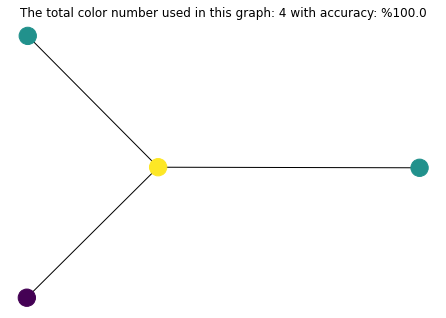

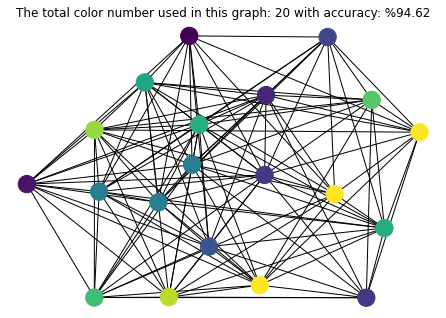

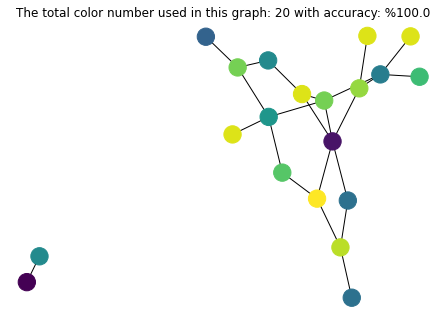

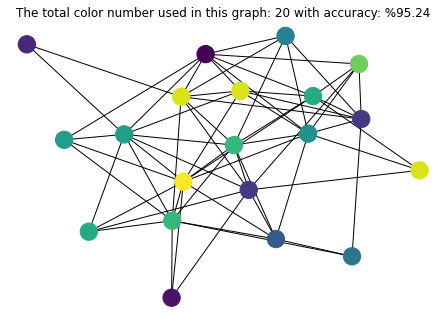

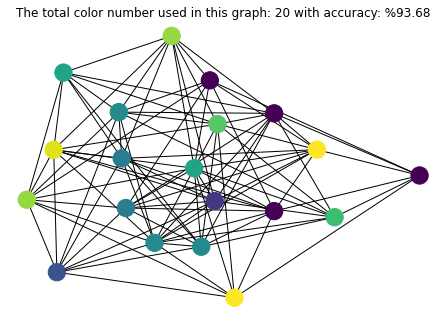

In [304]:
plot_graphs(ga_results)

### 🏁 End Point

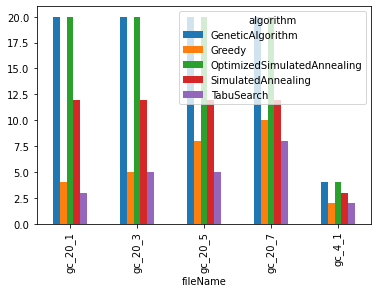

In [300]:
plot_results()